      cfi contract_type exercise_style expiration_date primary_exchange  \
0  OCASPS          call       american      2025-01-02             BATO   
1  OCASPS          call       american      2025-01-02             BATO   
2  OCASPS          call       american      2025-01-02             BATO   
3  OCASPS          call       american      2025-01-02             BATO   
4  OCASPS          call       american      2025-01-02             BATO   

   shares_per_contract  strike_price                ticker underlying_ticker  
0                  100         400.0  O:SPY250102C00400000               SPY  
1                  100         410.0  O:SPY250102C00410000               SPY  
2                  100         420.0  O:SPY250102C00420000               SPY  
3                  100         430.0  O:SPY250102C00430000               SPY  
4                  100         440.0  O:SPY250102C00440000               SPY  


Text(0.5, 1.0, 'Distribution of Strike Prices')

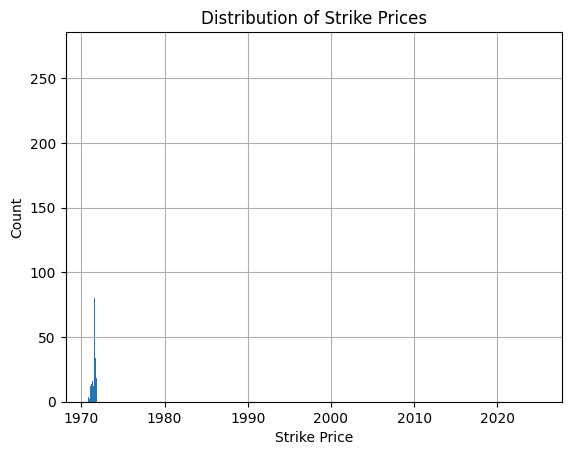

In [ ]:
import typing
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

contracts_fname:str  = "SPY_JAN_1_2025_JAN_7_2025.json"

notebook_dir = os.getcwd()
json_path = os.path.join(notebook_dir, "data", contracts_fname)  # Replace FILE-NAME.json as needed

with open(json_path, "r") as f:
    data = json.load(f)
contracts = data['results']

df = pd.DataFrame(contracts)
df['shares_per_contract'] = pd.to_numeric(df['shares_per_contract'], errors='coerce')
df['strike_price'] = pd.to_numeric(df['strike_price'], errors='coerce')
df['expiration_date'] = pd.to_datetime(df['expiration_date'], errors='coerce')

df.head()
df.describe(include='all')

df['strike_price'].hist(bins=30)
df['expiration_date'].hist(bins=30)

plt.xlabel("Strike Price")
plt.ylabel("Count")
plt.title("Distribution of Strike Prices")
#plt.show()